In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os
import numpy as np
!pip install numpy matplotlib
import matplotlib.pyplot as plt

###Загрузка весов с yandex диска

In [ ]:
#загружаем веса yolov8 c yandex диска
import requests
from urllib.parse import urlencode

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/q5mNyn16mkYJeg'

# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

# Загружаем файл и сохраняем его
download_response = requests.get(download_url)
with open('weight.zip', 'wb') as f:
    f.write(download_response.content)




In [ ]:
#разархивировать полученные данные
import zipfile

# Путь к вашему архиву .zip
zip_path = '/content/weight.zip'

# Папка, в которую вы хотите извлечь файлы
extracted_folder = '/content/'

# Создайте папку для извлечения файлов (если она не существует)
os.makedirs(extracted_folder, exist_ok=True)

# Распаковка архива
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)

print("Архив успешно разархивирован.")

Архив успешно разархивирован.


###Загрузка данных с yandex диска

In [ ]:
#загружаем файлы с диска
import requests
from urllib.parse import urlencode

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/mksPfmDDJHKDOg'

# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

# Загружаем файл и сохраняем его
download_response = requests.get(download_url)
with open('dataset.zip', 'wb') as f:
    f.write(download_response.content)

In [ ]:
#разархивировать полученные данные
import zipfile

# Путь к вашему архиву .zip
zip_path = '/content/dataset.zip'

# Папка, в которую вы хотите извлечь файлы
extracted_folder = '/content/dataset'

# Создайте папку для извлечения файлов (если она не существует)
os.makedirs(extracted_folder, exist_ok=True)

# Распаковка архива
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)

print("Архив успешно разархивирован.")

Архив успешно разархивирован.


###Создание распределенного датасета

In [ ]:
# Папка с изображениями
#image_folder_path = extracted_folder + '/train/images'
image_folder_path = "/content/example/images"

# Папка с файлами меток (предполагаем, что названия файлов совпадают с названиями изображений без расширений)
#label_folder_path = extracted_folder+'/train/labels'
label_folder_path = "/content/example/labels"

# Получение списков файлов изображений и меток
image_files = sorted([f for f in os.listdir(image_folder_path) if f.endswith('.jpg') or f.endswith('.png')])
label_files = sorted([f for f in os.listdir(label_folder_path) if f.endswith('.txt')])

# Проверка соответствия файлов
assert len(image_files) == len(label_files), "Количество файлов изображений и меток не совпадает."

# Сопоставление файлов изображений и меток
data_pairs = [(os.path.join(image_folder_path, img), os.path.join(label_folder_path, label)) for img, label in zip(image_files, label_files)]

# Разделение на обучающую, валидационную и тестовую выборки
data_pairs_train, data_pairs_temp = train_test_split(data_pairs, test_size=0.2, random_state=34)
data_pairs_val, data_pairs_test = train_test_split(data_pairs_temp, test_size=0.5, random_state=34)

#для равномерно распределенных наборов данных
#data_pairs_train, data_pairs_temp = train_test_split(data_pairs, test_size=0.3, stratify=[label for _, label in data_pairs], random_state=34)
#data_pairs_val, data_pairs_test = train_test_split(data_pairs_temp, test_size=0.5, stratify=[label for _, label in data_pairs_temp], random_state=34)

In [ ]:
# Функция для вывода распределения классов в выборке
def plot_class_distribution(labels_files, dataset_name):
    # Извлечение меток классов
    labels = []
    for label_file in labels_files:
       with open(os.path.join(label_folder_path, label_file), 'r') as file:
          for line in file:
              # Разделение строки на числа и добавление первого числа в список меток
              label = line.split()[0]
              labels.append(label)
    unique_classes, counts = np.unique(labels, return_counts=True)
    # Получение реальных меток классов (предполагаем, что метки - целые числа)
    class_labels = [int(label) for label in unique_classes]

    plt.bar(class_labels, counts)
    plt.title("Class distribution " + dataset_name)
    plt.xlabel("Class")
    plt.ylabel("Number of samples")
    plt.xticks(class_labels)  # Устанавливаем метки классов на оси x
    plt.show()

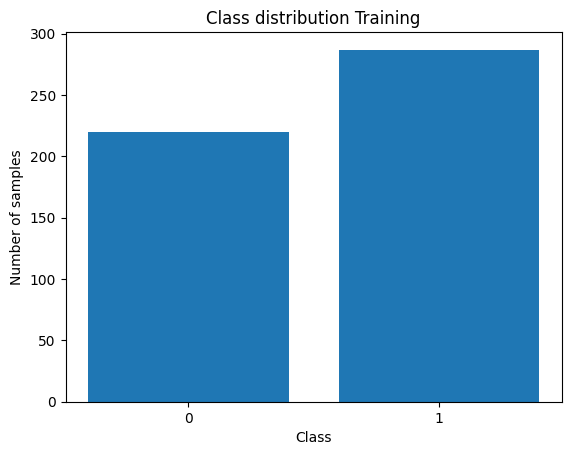

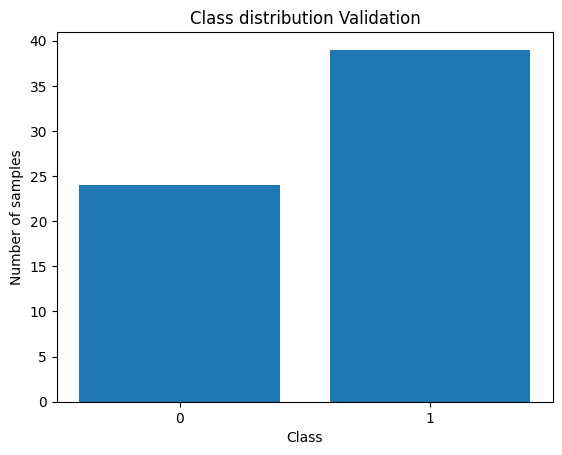

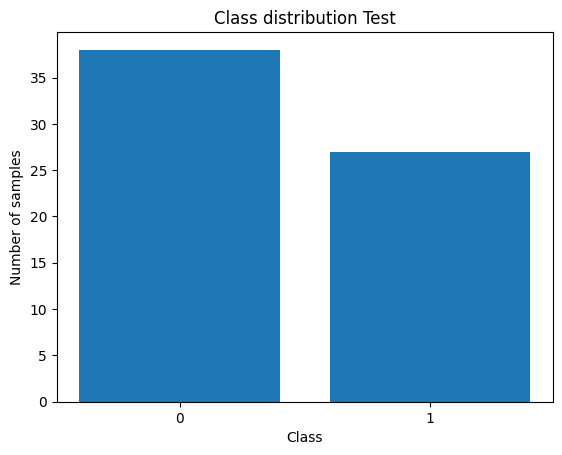

In [ ]:
# Извлечение массивов из меток
labels_train = [label for _, label in data_pairs_train]
labels_val = [label for _, label in data_pairs_val]
labels_test = [label for _, label in data_pairs_test]

# Вывод распределения классов для обучающей, валидационной и тестовой выборок
plot_class_distribution(labels_train, "Training")
plot_class_distribution(labels_val, "Validation")
plot_class_distribution(labels_test, "Test")

### Если выборка подходит, то можно копировать файлы по папкам (и далее опять проверить распределение классов уже в папках)

In [ ]:
import shutil

In [ ]:
#функция для копирования файлов
def copy_files(source_folder, destination_folder, file_list):
    for file_name in file_list:
        source_path = os.path.join(source_folder, file_name)
        destination_path = os.path.join(destination_folder, file_name)
        shutil.copy2(source_path, destination_path)

In [ ]:
new_dataset_root = '/content/new_dataset_test'

# Копирование файлов для обучающей выборки
new_train_folder = os.path.join(new_dataset_root, 'train', 'images')
os.makedirs(new_train_folder, exist_ok=True)
copy_files(image_folder_path, new_train_folder, [os.path.basename(img) for img, _ in data_pairs_train])
new_train_folder = os.path.join(new_dataset_root, 'train', 'labels')
os.makedirs(new_train_folder, exist_ok=True)
copy_files(label_folder_path, new_train_folder, [os.path.basename(label) for _, label in data_pairs_train])

# Копирование файлов для валидационной выборки
new_val_folder = os.path.join(new_dataset_root, 'valid', 'images')
os.makedirs(new_val_folder, exist_ok=True)
copy_files(image_folder_path, new_val_folder, [os.path.basename(img) for img, _ in data_pairs_val])
new_val_folder = os.path.join(new_dataset_root, 'valid', 'labels')
os.makedirs(new_val_folder, exist_ok=True)
copy_files(label_folder_path, new_val_folder, [os.path.basename(label) for _, label in data_pairs_val])

# Копирование файлов для тестовой выборки
new_test_folder = os.path.join(new_dataset_root, 'test', 'images')
os.makedirs(new_test_folder, exist_ok=True)
copy_files(image_folder_path, new_test_folder, [os.path.basename(img) for img, _ in data_pairs_test])
new_test_folder = os.path.join(new_dataset_root, 'test', 'labels')
os.makedirs(new_test_folder, exist_ok=True)
copy_files(label_folder_path, new_test_folder, [os.path.basename(label) for _, label in data_pairs_test])

In [ ]:
#функция для показа распределения классов в каждой выборке(папке)
def get_class_distribution(label_folder_path, name):
    # Получение списка файлов с метками
    label_files = [f for f in os.listdir(label_folder_path) if f.endswith('.txt')]

    # Извлечение меток классов
    labels = []
    for label_file in label_files:
       with open(os.path.join(label_folder_path, label_file), 'r') as file:
          for line in file:
              # Разделение строки на числа и добавление первого числа в список меток
              label = line.split()[0]
              labels.append(label)    # Вывод распределения классов
    unique_classes, counts = np.unique(labels, return_counts=True)

    # Получение реальных меток классов (предполагаем, что метки - целые числа)
    class_labels = [int(label) for label in unique_classes]

    plt.bar(class_labels, counts)
    plt.title("Class distribution" +" " + name)
    plt.xlabel("Class")
    plt.ylabel("Number of samples")
    plt.xticks(class_labels)  # Устанавливаем метки классов на оси x
    plt.show()

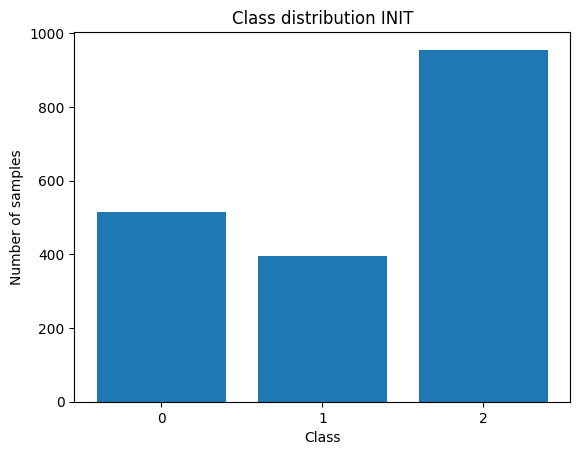

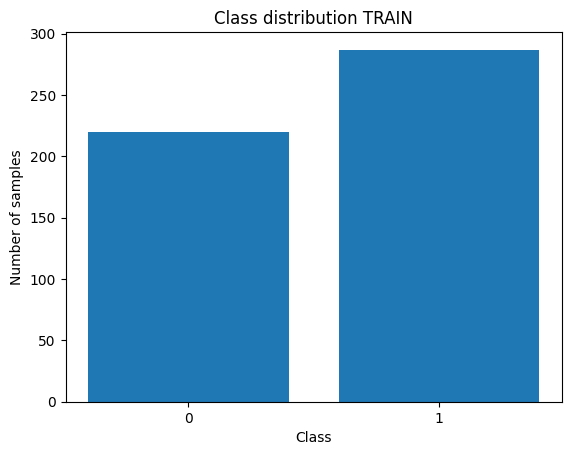

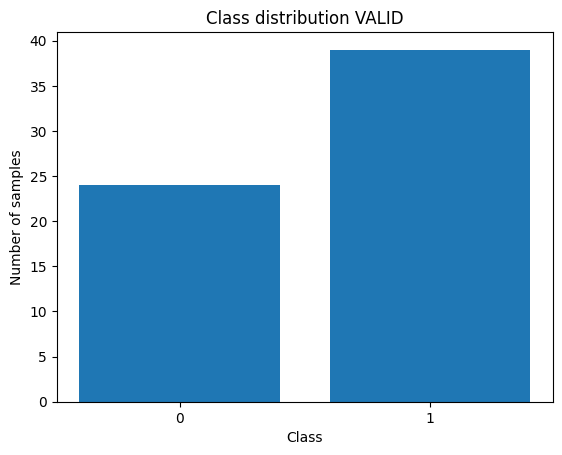

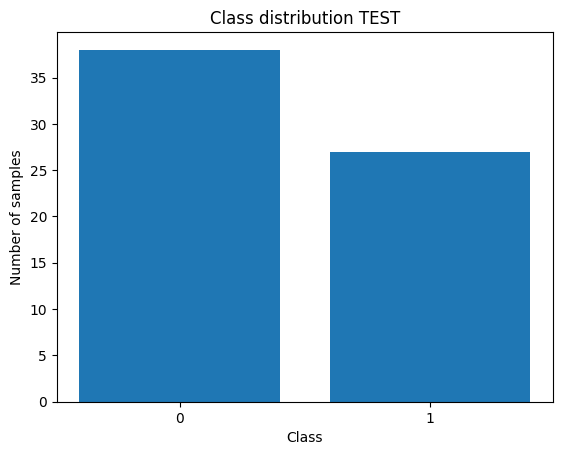

In [ ]:
# Вывод распределения классов для обучающей, валидационной и тестовой выборок
# Папка с файлами меток для обучающей выборки
label_folder_train = new_dataset_root+'/train/labels'

# Папка с файлами меток для валидационной выборки
label_folder_val = new_dataset_root+'/valid/labels'

# Папка с файлами меток для тестовой выборки
label_folder_test = new_dataset_root+'/test/labels'

# Папка с файлами меток для начальной выборки
label_folder_init = '/content/dataset/train/labels'

# Вывод распределения классов для каждой выборки
get_class_distribution(label_folder_init, "INIT")
get_class_distribution(label_folder_train, "TRAIN")
get_class_distribution(label_folder_val, "VALID")
get_class_distribution(label_folder_test, "TEST")

In [ ]:
!pip install ultralytics
from ultralytics import YOLO
from google.colab import files

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 660.5/660.5 kB 3.8 MB/s eta 0:00:00


##Обучение модели на своем датасете


In [ ]:
!cp /content/dataset/data.yaml /content/new_dataset_test

In [ ]:
from ultralytics import YOLO


import subprocess

# Замените это на правильные пути и параметры
yolo_command = "yolo task=detect mode=train model=yolov8n.pt data=/content/new_dataset_test/data.yaml epochs=23"

# Выполнение команды
result = subprocess.run(yolo_command, shell=True, capture_output=True, text=True)
print(result.stdout)
print(result.stderr)


Ultralytics YOLOv8.0.227 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU (AMD EPYC 7B12)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/new_dataset_test/data.yaml, epochs=23, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torch

##Применяем обученную модель к изображениям

In [ ]:
yolo_command = "yolo task=detect mode=predict model=/content/runs/detect/train4/weights/best.pt source=/content/file369_267.avi"

result = subprocess.run(yolo_command, shell=True, capture_output=True, text=True)
print(result.stdout)
print(result.stderr)


Ultralytics YOLOv8.0.225 🚀 Python-3.10.12 torch-2.1.0+cu118 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs

video 1/1 (1/500) /content/file369_267.avi: 480x640 2 0s, 8 2s, 9 5s, 213.4ms
video 1/1 (2/500) /content/file369_267.avi: 480x640 2 0s, 8 2s, 9 5s, 174.3ms
video 1/1 (3/500) /content/file369_267.avi: 480x640 2 0s, 7 2s, 9 5s, 173.7ms
video 1/1 (4/500) /content/file369_267.avi: 480x640 2 0s, 7 2s, 9 5s, 162.7ms
video 1/1 (5/500) /content/file369_267.avi: 480x640 2 0s, 7 2s, 9 5s, 161.7ms
video 1/1 (6/500) /content/file369_267.avi: 480x640 2 0s, 8 2s, 9 5s, 155.9ms
video 1/1 (7/500) /content/file369_267.avi: 480x640 2 0s, 8 2s, 9 5s, 152.6ms
video 1/1 (8/500) /content/file369_267.avi: 480x640 2 0s, 8 2s, 9 5s, 153.3ms
video 1/1 (9/500) /content/file369_267.avi: 480x640 2 0s, 8 2s, 9 5s, 164.8ms
video 1/1 (10/500) /content/file369_267.avi: 480x640 2 0s, 8 2s, 9 5s, 153.3ms
video 1/1 (11/500) /content/file369_267.avi: 480x640 2

##Проводим эсперименты по обнаружению касок и голов без касок в обрезанных изображениях

###Подготовка датасета

In [ ]:
import os
import cv2
import shutil

In [ ]:
def parse_yolo_annotation(annotation_path):
    with open(annotation_path, 'r') as file:
        lines = file.readlines()

    # Каждая строка аннотации содержит: класс x_center y_center width height
    annotations = [list(map(float, line.strip().split())) for line in lines]

    return annotations

In [ ]:
def create_directory_if_not_exists(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)


In [ ]:
# Задайте путь к директории с аннотациями и изображениями
data_dir = '/content/dataset/train/'
data_dir_labels = data_dir+'/labels'
data_dir_img = data_dir+'/images'
# Задайте класс, который нужно выделить (например, класс 0)
class_to_extract = 2.0

# Проход по всем файлам аннотаций
for annotation_file in os.listdir(data_dir_labels):
    if annotation_file.endswith('.txt'):
        annotation_path = os.path.join(data_dir_labels,annotation_file)
        # Загрузка аннотации YOLO
        annotations = parse_yolo_annotation(annotation_path)
        # Выделение аннотаций с классом, который нужно выделить
        selected_annotations = [bbox for bbox in annotations if int(bbox[0]) == class_to_extract]
        # Обновление исходных аннотаций, исключая аннотации с классом, который нужно выделить
        filtered_annotations = [bbox for bbox in annotations if int(bbox[0]) != class_to_extract]

        file2path = annotation_file.replace('labels', 'images').replace('.txt', '.jpg')
        file2path = os.path.join(data_dir_img, file2path)
        image = cv2.imread(file2path)
        height_image_source, width_image_source = image.shape[:2]

        for idx, selected_bbox in enumerate(selected_annotations):
            write_file = 0
            # Создание новой директории для выделенных аннотаций
            output_dir_labels = "example/labels"
            output_dir_img = "example/images"
            create_directory_if_not_exists(output_dir_labels)
            create_directory_if_not_exists(output_dir_img)
            selected_class_id, selected_x_center, selected_y_center, selected_width, selected_height = selected_bbox

            # Создание нового файла аннотации для выделенной аннотации
            output_annotation_path = os.path.join(output_dir_labels, f'{annotation_file.replace(".txt", "")}_{idx}.txt')

            # Проверка пересечения bounding box'ов между классами
            for filtered_bbox in filtered_annotations:
              class_id, x_center, y_center, width, height = filtered_bbox
              # Вычисление границ bounding box'ов
              x1 = x_center - width / 2
              y1 = y_center - height / 2
              x2 = x_center + width / 2
              y2 = y_center + height / 2

              selected_x1 = selected_x_center - selected_width / 2
              selected_y1 = selected_y_center - selected_height / 2
              selected_x2 = selected_x_center + selected_width / 2
              selected_y2 = selected_y_center + selected_height / 2

              # Проверка пересечения bounding box'ов
              if (x1 > selected_x1 and x2 < selected_x2 and y1 > selected_y1 and y2 < selected_y2):
                  # Если есть пересечение, записываем информацию в соответствующий файл аннотации
                  write_file = 1
                  # надо пересчитать координаты
                  x_tmp1 = (x1 - selected_x1)/selected_width
                  x_tmp2 = (x2 - selected_x1)/selected_width
                  y_tmp1 = (y1 - selected_y1)/selected_height
                  y_tmp2 = (y2 - selected_y1)/selected_height
                  width_tmp = x_tmp2 - x_tmp1
                  height_tmp = y_tmp2 - y_tmp1
                  x_center_tmp = x_tmp1+width_tmp/2
                  y_center_tmp = y_tmp1+height_tmp/2
                  filtered_bbox_tmp = int(class_id), x_center_tmp, y_center_tmp, width_tmp, height_tmp
                  with open(output_annotation_path, 'a') as output_file:
                      output_file.write(' '.join(map(str, filtered_bbox_tmp)) + '\n')

            if write_file == 1:
              # Создание нового файла изображения для выделенной аннотации
              image_path = os.path.join(data_dir_img, annotation_file.replace('.txt', '.jpg'))
              output_image_path = os.path.join(output_dir_img, f'{annotation_file.replace(".txt", "")}_{idx}.jpg')
              image = cv2.imread(image_path)
              height_img, width_img = image.shape[:2]
              x_center = selected_x_center*width_img
              y_center = selected_y_center*height_img
              selected_width = selected_width*width_img
              selected_height = selected_height*height_img
              x_min = int(x_center - selected_width / 2)
              x_max = int(x_center + selected_width / 2)
              y_min = int(y_center - selected_height / 2)
              y_max = int(y_center + selected_height / 2)

              cropped_image = image[y_min:y_max, x_min:x_max]
              cv2.imwrite(output_image_path, cropped_image)




###Проверка созданного датасета

In [ ]:
def get_random_file(directory):
    # Получаем список файлов в директории
    files = [file for file in os.listdir(directory) if os.path.isfile(os.path.join(directory, file))]

    # Выбираем случайный файл из списка
    if files:
        return os.path.join(directory, random.choice(files))
    else:
        return None

In [ ]:
#проверка созданного датасета
import os
import random
import cv2
import matplotlib.pyplot as plt

/content/example/images/file369_169_data_000009_jpg.rf.0c6f0bc54fbdee08f72d150fa68b262c_2.jpg
0.0 0.3598181818181818 0.06525300003560888 0.38636363636363635 0.1246305594131683
281 110


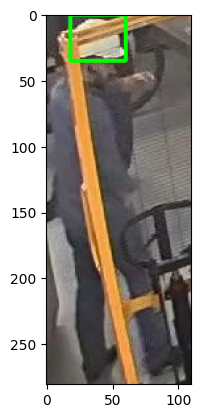

In [ ]:
# Пример использования
directory = "/content/example"
directory2image = directory+"/images"
directory2label = directory+"/labels"

random_file = get_random_file(directory2image)
print(random_file)
annotation_path = random_file.replace('images', 'labels').replace('.jpg', '.txt')

image = cv2.imread(random_file)
height_img, width_img = image.shape[:2]

# Отображение изображения и вырезанного куска (для визуализации)
# Рисуем bounding box
annotations = parse_yolo_annotation(annotation_path)
for annotation in annotations:
    class_id, x_center, y_center, width, height = map(float, annotation)
    print(class_id, x_center, y_center, width, height)
    print(height_img, width_img)
    # Обработка или вывод информации об аннотации
    x_min =int((x_center - width / 2)*width_img)
    x_max =int((x_center + width / 2)*width_img)
    y_min =int((y_center - height / 2)*height_img)
    y_max =int((y_center + height / 2)*height_img)
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

# Отображаем изображение
# Преобразование цветовой палитры изображения из BGR в RGB для отображения через matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Отображаем изображение
plt.imshow(image_rgb)
plt.show()

###Применяем нейросеть yolo8 обученную на новом датасете

In [ ]:
# Создаем пустой словарь (map)
my_map = {}

In [ ]:
import cv2
import matplotlib.pyplot as plt
import datetime

def defineHurdHut(image, box, save_dir, id_person):
  int_list = [int(x) for x in box]
  (x_min, y_min, x_max, y_max) = int_list
  #print(x_min, y_min, x_max, y_max)
  # Вырезаем кусок изображения по bounding box
  cropped_image = image[y_min:y_max, x_min:x_max]

  # Подаем вырезанный кусок на обработку (например, детекция объектов, классификация и т.д.)
  # В данном случае просто выводим размеры вырезанного куска
  #print("Размеры вырезанного куска:", cropped_image.shape)
  # Сохраняем вырезанное изображение в файл
  if cropped_image is not None and cropped_image.size != 0:
    cv2.imwrite('/content/cropped_image.jpg', cropped_image)
  else:
      print("Cropped image is empty.")
      return
  # Отображение изображения и вырезанного куска (для визуализации)
  # Рисуем bounding box
  cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

  # Отображаем оригинальное изображение
  plt.clf()
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.title("Original Image")
  plt.axis("off")
  plt.show()

  # Берем новую модель
  model = YOLO('weight/best.pt')
  # Обнаруживаем только класс без каски в режиме генератора (stream)
  result = model.predict(cropped_image, stream=True, classes=1, device='cpu')
  for i, r in enumerate(result):
    # При детекции головы без каски
    if (len(r.boxes) > 0):
      if id_person not in my_map:
          my_map[id_person] = 1
          current_time = datetime.datetime.utcnow()
          formatted_time = current_time.strftime("%d%m%Y_%H%M%S")  # Форматирует время как 'ДДММГГГГ_ЧЧММСС'
          file_name = save_dir+'/person_'+formatted_time+'.jpg'
          cv2.imwrite(file_name, cropped_image)
          # Получаем изображение, вырезаем bb
          boxes = r.boxes.xyxy
          numbers_list = boxes.tolist()
          for box_d in numbers_list:
            int_list_d = [int(x) for x in box_d]
            (x_min_d, y_min_d, x_max_d, y_max_d) = int_list_d
            # Рисуем bounding box
            cv2.rectangle(cropped_image, (x_min_d, y_min_d), (x_max_d, y_max_d), (0, 255, 0), 2)

  plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
  plt.title("Cropped Image")
  plt.axis("off")
  plt.show()
  # Вывод результата
  #print("Стандартный вывод:")
  #print(result.stdout)

  # Вывод ошибок
  #print("Стандартная ошибка:")
  #print(result.stderr)


##Основная программа, в которой сначала происходит нахождение людей на видео, затем согласно bb вырезаются кусочки изображения и подаются в новую сетку

In [ ]:
import cv2
import matplotlib.pyplot as plt
import datetime

def defineHurdHut(image, box, save_dir):
  int_list = [int(x) for x in box]
  (x_min, y_min, x_max, y_max) = int_list
  #print(x_min, y_min, x_max, y_max)
  # Вырезаем кусок изображения по bounding box
  cropped_image = image[y_min:y_max, x_min:x_max]

  # Подаем вырезанный кусок на обработку (например, детекция объектов, классификация и т.д.)
  # В данном случае просто выводим размеры вырезанного куска
  #print("Размеры вырезанного куска:", cropped_image.shape)
  # Сохраняем вырезанное изображение в файл
  if cropped_image is not None and cropped_image.size != 0:
    cv2.imwrite('/content/cropped_image.jpg', cropped_image)
  else:
      print("Cropped image is empty.")
      return
  # Отображение изображения и вырезанного куска (для визуализации)
  # Рисуем bounding box
  cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

  # Отображаем оригинальное изображение
  plt.clf()
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.title("Original Image")
  plt.axis("off")
  plt.show()

  # Берем новую модель
  model = YOLO('weight/best.pt')
  # Обнаруживаем только класс без каски в режиме генератора (stream)
  result = model.predict(cropped_image, stream=True, classes=1, device='cpu')
  for i, r in enumerate(result):
    # При детекции головы без каски
    if (len(r.boxes) > 0):
          current_time = datetime.datetime.utcnow()
          formatted_time = current_time.strftime("%d%m%Y_%H%M%S")  # Форматирует время как 'ДДММГГГГ_ЧЧММСС'
          file_name = save_dir+'/person_'+formatted_time+'.jpg'
          cv2.imwrite(file_name, cropped_image)
          # Получаем изображение, вырезаем bb
          boxes = r.boxes.xyxy
          numbers_list = boxes.tolist()
          for box_d in numbers_list:
            int_list_d = [int(x) for x in box_d]
            (x_min_d, y_min_d, x_max_d, y_max_d) = int_list_d
            # Рисуем bounding box
            cv2.rectangle(cropped_image, (x_min_d, y_min_d), (x_max_d, y_max_d), (0, 255, 0), 2)

  plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
  plt.title("Cropped Image")
  plt.axis("off")
  plt.show()
  # Вывод результата
  #print("Стандартный вывод:")
  #print(result.stdout)

  # Вывод ошибок
  #print("Стандартная ошибка:")
  #print(result.stderr)

In [ ]:
!pip install ultralytics
from ultralytics import YOLO
import subprocess

In [ ]:
import os
#функция  распознавания человека без каски на видео
#video_file - текущий видеофайл
#save_dir - Куда будем сохранять изображения
def mainProgram(video_file_path, save_dir, file_yolo):
    # Если нет каталога, создадим его
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    # Берем стандартную модель
    model = YOLO(file_yolo)
    # Обнаруживаем только нулевой класс (person) в режиме генератора (stream)
    image = cv2.imread(video_file_path)
    res = model.predict(video_file_path, stream=True, classes=0, device='cpu')
    for i, r in enumerate(res):
       # При детекции человека
       if (len(r.boxes) > 0):
          # Получаем изображение, вырезаем bb
          img = r.orig_img
          boxes = r.boxes.xyxy
          numbers_list = boxes.tolist()
          for box in numbers_list:
          # вырезаем каждый bb и далее отправляем к следующей нейросети
              defineHurdHut(img, box, save_dir)

In [ ]:
mainProgram("/content/file369_267.avi", "exam", "/content/weight/yolov8n.pt")

In [ ]:
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15833, done.
remote: Total 15833 (delta 0), reused 0 (delta 0), pack-reused 15833
Receiving objects: 100% (15833/15833), 14.39 MiB | 11.60 MiB/s, done.
Resolving deltas: 100% (10666/10666), done.


##Трекинг

In [ ]:
!pip install ultralytics
from ultralytics import YOLO

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 695.2/695.2 kB 6.0 MB/s eta 0:00:00


In [ ]:
!pip install filterpy
!pip install torch torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110458 sha256=d78221e6a35a38205e7da7f41abad6e28478fd3986d84e22d1585c16b01ad7e5
  Stored in directory: /root/.cache/pip/wheels/0f/0c/ea/218f266af4ad626897562199fbbcba521b8497303200186102
Successfully built filterpy


In [ ]:
import os
import numpy as np
# Открытие видеофайла
from google.colab.patches import cv2_imshow
!git clone https://github.com/abewley/sort.git
import sys
sys.path.insert(0, '/content/sort/')
from sort import Sort

# Создаем трекер SORT
tracker = Sort()

fatal: destination path 'sort' already exists and is not an empty directory.


In [ ]:
#функция  распознавания человека без каски на видео
#video_file - текущий видеофайл
#save_dir - Куда будем сохранять изображения
#file_yolo - веса для yolo8
def mainProgram(video_file_path, save_dir, file_yolo):
    # Если нет каталога, создадим его
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    # Берем стандартную модель
    model = YOLO(file_yolo)

    cap = cv2.VideoCapture(video_file_path)

    # Получение размеров кадра и частоты кадров из исходного видео
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Создание объекта VideoWriter
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter('output_video.avi', fourcc, fps, (frame_width, frame_height))
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        res = model.predict(frame, stream=True, classes=0, device='cpu')
        detections = []
        n = 0 #количество распознанных людей
        for i, r in enumerate(res):
            # При детекции человека
            if (len(r.boxes) > 0):
                n=n+1
                # Получаем изображение, вырезаем bb
                img = r.orig_img
                boxes = r.boxes.xyxy
                numbers_list = boxes.tolist()
                for box in numbers_list:
                    x_min, y_min, x_max, y_max = map(int, box[:4])
                    conf = box[4] if len(box) > 4 else 1  # используем уверенность, если она есть, иначе 1
                    detections.append([x_min, y_min, x_max, y_max, conf])
        #если в кадре не оказалось людей, то можно обнулять список id трекера
        if (n==0):
          my_map.clear()

        tracked_objects = tracker.update(np.array(detections))

        for track in tracked_objects:
            x1, y1, x2, y2, obj_id = map(int, track)
            # Отображение результатов трекинга
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, f"ID: {obj_id}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            # вырезаем каждый bb и далее отправляем к следующей нейросети
            box = [x1, y1, x2, y2]
            defineHurdHut(img, box, save_dir,obj_id)

        # Запись обработанного кадра в файл
        out.write(frame)


        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

In [ ]:
mainProgram("/content/file369_267.avi", "exam2", "/content/weight/yolov8n.pt")

###отображаем полученное обработанное видео

In [ ]:
!pip install ffmpeg-python

In [ ]:
from IPython.display import Image, clear_output
from base64 import b64encode
from IPython.display import HTML
import cv2
import ffmpeg
import subprocess

In [ ]:
# Устанавливаем ffmpeg
!apt-get install ffmpeg

# Конвертируем AVI в MP4
!ffmpeg -i output_video.avi output_video.mp4

# Импортируем необходимые библиотеки для отображения видео
from IPython.display import HTML
from base64 import b64encode

# Открываем сконвертированный файл
mp4 = open('output_video.mp4','rb').read()

# Кодируем видео в base64 и отображаем его в HTML
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
^C
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --

FileNotFoundError: [Errno 2] No such file or directory: 'output_video.mp4'

###захват видео из внешних источников

In [ ]:
!pip install yt_dlp

In [ ]:
!pip install -U vidgear[core]
from vidgear.gears import CamGear
from google.colab.patches import cv2_imshow
import cv2

In [ ]:
rm -r exam2

In [ ]:
#функция  распознавания человека без каски на видео
#video_file - текущий видеофайл
#save_dir - Куда будем сохранять изображения
#file_yolo - веса для yolo8
def mainProgram2(video_file_path, save_dir, file_yolo):
    # Если нет каталога, создадим его
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    # Берем стандартную модель
    model = YOLO(file_yolo)

    # параметр качества
    options = {"STREAM_RESOLUTION": "360p"}

    cap_tmp = cv2.VideoCapture(video_file_path)

    # Получение размеров кадра и частоты кадров из исходного видео
    frame_width = int(cap_tmp.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap_tmp.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap_tmp.get(cv2.CAP_PROP_FPS)


    options = { "CAP_PROP_FRAME_WIDTH": frame_width,
                "CAP_PROP_FRAME_HEIGHT": frame_height,
                "CAP_PROP_FPS": fps}
    # делаем захват видео по ссылке
    cap = CamGear(
        source=video_file_path,
        stream_mode=True,
        **options).start()


    # Создание объекта VideoWriter
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter('output_video.avi', fourcc, fps, (frame_width, frame_height))
    detections = [[0,0,0,0,0]]

    while True:
        frame = cap.read()

        if frame is None:
          break

        res = model.predict(frame, stream=True, classes=0, device='cpu')
        n = 0 #количество распознанных людей
        for i, r in enumerate(res):
            # При детекции человека
            if (len(r.boxes) > 0):
                n=n+1
                # Получаем изображение, вырезаем bb
                img = r.orig_img
                boxes = r.boxes.xyxy
                numbers_list = boxes.tolist()
                for box in numbers_list:
                    x_min, y_min, x_max, y_max = map(int, box[:4])
                    conf = box[4] if len(box) > 4 else 1  # используем уверенность, если она есть, иначе 1
                    detections.append([x_min, y_min, x_max, y_max, conf])

        #если в кадре не оказалось людей, то можно обнулять список id трекера
        print(n)
        if (n==0):
          my_map.clear()

        tracked_objects = tracker.update(np.array(detections))

        for track in tracked_objects:
            x1, y1, x2, y2, obj_id = map(int, track)
            # Отображение результатов трекинга
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, f"ID: {obj_id}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            # вырезаем каждый bb и далее отправляем к следующей нейросети
            box = [x1, y1, x2, y2]
            defineHurdHut(img, box, save_dir,obj_id)

        # Запись обработанного кадра в файл
        if frame is not None:
          out.write(frame)


        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

In [ ]:
mainProgram2("https://www.youtube.com/watch?v=woNYD5UUd2k&t=33s", "exam2", "/content/weight/yolov8n.pt")

##https://www.youtube.com/watch?v=woNYD5UUd2k&t=33s


15:26:39 ::    Helper     :: WARNING  :: GStreamer not found!
15:26:39 ::    CamGear    ::   INFO   :: Verifying Streaming URL using yt-dlp backend. Please wait...
ERROR: [youtube] woNYD5UUd2k: woNYD5UUd2k: Failed to parse JSON (caused by JSONDecodeError("Expecting value in '': line 1 column 1 (char 0)")); please report this issue on  https://github.com/yt-dlp/yt-dlp/issues?q= , filling out the appropriate issue template. Confirm you are on the latest version using  yt-dlp -U


ValueError: [CamGear:ERROR] :: Stream Mode is enabled but Input URL is invalid!

In [ ]:
# параметр качества
options = {"STREAM_RESOLUTION": "360p"}

# options = {"CAP_PROP_FRAME_WIDTH": 320,
#            "CAP_PROP_FRAME_HEIGHT": 240,
#            "CAP_PROP_FPS": 60}
camera_url = "https://www.youtube.com/watch?v=woNYD5UUd2k"
# делаем захват видео по ссылке
stream = CamGear(
    source=camera_url,
    stream_mode=True,
    **options).start()

# возьмем первые 10 кадров видео
for i in range(100):

    # считываем кадр из видео
    frame = stream.read()

    # проверяем не пустой ли это кадр
    if frame is None:
        break

    # выводим результат на экран
    cv2_imshow(frame)

# закрываем видеофайл
stream.stop()

15:16:38 ::    Helper     :: WARNING  :: GStreamer not found!
15:16:38 ::    CamGear    ::   INFO   :: Verifying Streaming URL using yt-dlp backend. Please wait...
ERROR: [youtube] woNYD5UUd2k: woNYD5UUd2k: Failed to parse JSON (caused by JSONDecodeError("Expecting value in '': line 1 column 1 (char 0)")); please report this issue on  https://github.com/yt-dlp/yt-dlp/issues?q= , filling out the appropriate issue template. Confirm you are on the latest version using  yt-dlp -U


ValueError: [CamGear:ERROR] :: Stream Mode is enabled but Input URL is invalid!